In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
!pip install thefuzz


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/15/aa/3f4c7bcee2057a76562a5b33ecbd199be08cdb4443a02e26bd2c3cf6fc39/pip-23.3.2-py3-none-any.whl.metadata
  Using cached pip-23.3.2-py3-none-any.whl.metadata (3.5 kB)
Using cached pip-23.3.2-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
c:\python\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []
        qa_id = 0

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role": re.compile(r"[user|assistant]")})
            
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                text = convo[0].text
        
                if role == 'assistant':
                    
                    start_index = text.find("pythonCopy code")
                    end_index = text.rfind("\n")
        
                    if start_index != -1 and end_index != -1:
                        code_text = text[start_index + len("pythonCopy code"):end_index].strip()
        
                        convo_texts.append({
                            "qa_id": qa_id,
                            "code": code_text,
                            "role": role,
                            "text": text
                        })
                    qa_id += 1        
                else:
                    convo_texts.append({
                        "role": role,
                        "text": text,
                        "qa_id": qa_id
                    })
        
        code2convos[file_code] = convo_texts

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [00:13<00:00,  9.74it/s]


In [5]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'qa_id': 0,
 'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [6]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append({
                        "text": conv["text"],
                        "qa_id": conv["qa_id"]
            }
                )
    code2prompts[code] = user_prompts    

In [7]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [8]:
pprint(code2prompts["0031c86e-81f4-4eef-9e0e-28037abf9883"][1])

{'qa_id': 1,
 'text': 'Provide Python code to understand a dataset using Pandas. Find the '
         'shape of the dataset, display variable names, display a summary of '
         'the dataset with the info() function, and show the first 5 rows '
         'using the head() function.\n'}


In [9]:
code2response_codes = defaultdict(list)
for code , convos in code2convos.items():
    gpt_codes = []
    for conv in convos:
        if conv["role"] == "assistant":
            gpt_codes.append({
                        "code": conv["code"],
                        "qa_id": conv["qa_id"]
            }
                )
    code2response_codes[code] = gpt_codes 

In [10]:
pprint(code2response_codes["0031c86e-81f4-4eef-9e0e-28037abf9883"][1])

{'code': 'import pandas as pd\n'
         '\n'
         '# Load the dataset into a Pandas DataFrame\n'
         "file_path = 'cs412_hw1_dataset.csv'\n"
         'df = pd.read_csv(file_path)\n'
         '\n'
         '# 1. Find the shape of the dataset\n'
         'shape = df.shape\n'
         'print("Shape of the dataset (rows, columns):", shape)\n'
         '\n'
         '# 2. Display variable names (column names)\n'
         'variable_names = df.columns\n'
         'print("Variable names (column names):")\n'
         'for name in variable_names:\n'
         '    print(name)\n'
         '\n'
         '# 3. Display a summary of the dataset with the info() function\n'
         'print("\\nSummary of the dataset:")\n'
         'df.info()\n'
         '\n'
         '# 4. Show the first 5 rows using the head() function\n'
         'print("\\nFirst 5 rows of the dataset:")\n'
         'print(df.head())',
 'qa_id': 1}


In [11]:
questions = [    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset 
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing 
Understanding the Dataset: (5 pts)
Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
Display variable names (both dependent and independent).
Display the summary of the dataset. (Hint: You can use the **info** function)
Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: 

Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
    
"""Set X & y, split data 

Shuffle the dataset.
Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
Split training and test sets as 80% and 20%, respectively.
""",
    
#####################
"""Features and Correlations 

 Correlations of features with health 
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

 Feature Selection 
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

 Hypothetical Driver Features 
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

 __Note:__ You get can get help from GPT.
""",
    
#####################
"""Tune Hyperparameters 
 Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* 
""",
    
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen 
Re-train model with the hyperparameters you have chosen in part 5). 
Plot the tree you have trained. 
Hint: You can import the **plot_tree** function from the sklearn library.
""",
    
#####################
"""Test your classifier on the test set 
Predict the labels of testing data using the tree you have trained in step 6. 
Report the classification accuracy. 
Plot & investigate the confusion matrix. Fill the following blanks. 
The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",

"""Find the information gain on the first split """,

]

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Define stopwords and initialize stemmer and lemmatizer


stop_words = set(stopwords.words('english'))
porter_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:

# Preprocess prompts
preprocessed_prompts = []
for prompt in prompts:
    # Tokenize the prompt into words
    words = nltk.word_tokenize(prompt)
    
    # Remove stopwords
    words = [word for word in words if word.lower() not in stop_words]
    
    # Apply stemming
    stemmed_words = [porter_stemmer.stem(word) for word in words]
    
    # Apply lemmatization
    lemmatized_words = [wordnet_lemmatizer.lemmatize(word) for word in stemmed_words]
    
    # Join the preprocessed words back into a sentence
    preprocessed_prompt = ' '.join(lemmatized_words)
    
    # Append the preprocessed prompt to the list
    preprocessed_prompts.append(preprocessed_prompt)


In [14]:
# Preprocess questions
preprocessed_questions = []
for question in questions:
    # Tokenize the question into words
    words = nltk.word_tokenize(question)
    
    # Remove stopwords
    words = [word for word in words if word.lower() not in stop_words]
    
    # Apply stemming
    stemmed_words = [porter_stemmer.stem(word) for word in words]
    
    # Apply lemmatization
    lemmatized_words = [wordnet_lemmatizer.lemmatize(word) for word in stemmed_words]
    
    # Join the preprocessed words back into a sentence
    preprocessed_question = ' '.join(lemmatized_words)
    
    # Append the preprocessed question to the list
    preprocessed_questions.append(preprocessed_question)

In [15]:
preprocessed_questions[1]

'load train dataset * read .csv file panda librari'

In [16]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(preprocessed_prompts + preprocessed_questions)

In [17]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(preprocessed_questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticklabels,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
for code, user_prompts in code2prompts.items():
    preprocessed_user_prompts = []
    
    for user_prompt in user_prompts:
        # Tokenize the user prompt into words
        words = nltk.word_tokenize(user_prompt['text'])
        
        # Remove stopwords
        words = [word for word in words if word.lower() not in stop_words]
        
        # Apply stemming
        stemmed_words = [porter_stemmer.stem(word) for word in words]
        
        # Apply lemmatization
        lemmatized_words = [wordnet_lemmatizer.lemmatize(word) for word in stemmed_words]
        
        # Join the preprocessed words back into a sentence
        preprocessed_user_prompt = ' '.join(lemmatized_words)
        
        # Append the preprocessed user prompt to the list
        preprocessed_user_prompts.append(preprocessed_user_prompt)
    
    # Update the code2prompts dictionary with the preprocessed user prompts
    code2prompts[code] = preprocessed_user_prompts

In [19]:
pprint(code2prompts["0031c86e-81f4-4eef-9e0e-28037abf9883"][2])

('preprocess data 1 . check miss valu handl either drop fill common valu . '
 'ensur enough data train model . use % 80 data train % 20 test 2 . encod '
 "label map use map function . map name : - sex_map = { 'femal ' : 1 , 'male ' "
 ": 0 } - island_map = { 'bisco ' : 1 , 'dream ' : 2 , 'torgensen ' : 3 } - "
 "diet_map = { 'fish ' : 1 , 'krill ' : 2 , 'squid ' : 3 , 'parent ' : 4 } - "
 "life_stage_map = { 'chick ' : 1 , 'juvenil ' : 2 , 'adult ' : 3 } - "
 "health_metrics_map = { 'healthi ' : 1 , 'overweight ' : 2 , 'underweight ' : "
 "3 } dataset name 'df ' .")


In [20]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [21]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticklabels,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 4719)

In [23]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [24]:
code2cosine['0031c86e-81f4-4eef-9e0e-28037abf9883']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.123213,0.031749,0.054538,0.032109,0.005198,0.000000,0.017648,0.033246,0.000000,0.013102,0.018345,0.000000,0.006011,0.026535
1,0.331379,0.173481,0.063213,0.070134,0.048872,0.000000,0.017658,0.061711,0.000000,0.000000,0.000000,0.000000,0.000000,0.022888
2,0.008794,0.640595,0.399620,0.087091,0.039156,0.000000,0.112112,0.130218,0.047031,0.032330,0.064990,0.009202,0.039193,0.110706
3,0.015487,0.106191,0.155854,0.435028,0.073508,0.000000,0.088261,0.114897,0.086548,0.027979,0.124186,0.048617,0.016600,0.112060
4,0.020953,0.061860,0.012665,0.074792,0.303591,0.043053,0.193045,0.284937,0.281769,0.526414,0.440234,0.000000,0.000000,0.081724
5,0.000000,0.047142,0.056245,0.000000,0.014736,0.000000,0.036463,0.023589,0.000000,0.047254,0.038451,0.000000,0.017040,0.641061
6,0.000000,0.044689,0.096476,0.102168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011109,0.000000,0.000000,0.148312
7,0.000000,0.080073,0.169515,0.168890,0.013903,0.000000,0.024723,0.012483,0.000000,0.000000,0.062606,0.000000,0.016077,0.069459
8,0.000000,0.144401,0.000000,0.095218,0.000000,0.000000,0.038676,0.000000,0.000000,0.000000,0.000000,0.000000,0.054091,0.000000


In [25]:
preprocessed_questions[0]

"initi * first make copi notebook given starter . * make sure choos connect form upper right . * may upload data section left colab , right click .csv file get path file click `` copi path '' . use load data ."

In [26]:
"""code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores"""

'code2questionmapping = dict()\nfor code, cosine_scores in code2cosine.items():\n    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()\n\n\nquestion_mapping_scores = pd.DataFrame(code2questionmapping).T\nquestion_mapping_scores.reset_index(inplace=True)\nquestion_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)\nquestion_mapping_scores.rename(columns={"index" : "code"}, inplace=True)\n\nquestion_mapping_scores'

In [27]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Create a dictionary to store the sum of cosine similarity scores for each code and each question


code2questionmapping = {}

# Iterate over each code and its corresponding cosine similarity DataFrame
for code, cosine_scores_df in code2cosine.items():


    index = cosine_scores_df.idxmax().tolist() #indices
    values = cosine_scores_df.max().tolist() #values
    simi_list = [0] * 9
# Find the index of the maximum similarity score for each question
    for i in range(len(index)):
         if values[i]>1:
             values[i] = 1
         simi_list[index[i]] = values[i]

    # Store the total maximum scores in the code2questionmapping dictionary
    code2questionmapping[code] = simi_list



question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.0,0.331379,0.399620,0.048617,0.440234,0.641061,0.000000,0.000000,0.054091
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.0,0.826481,0.242436,0.861056,0.561350,0.945530,0.734476,0.461421,0.131359
2,041f950b-c013-409a-a642-cffff60b9d4b,0.0,0.000000,0.029160,0.050492,0.601981,0.000000,0.042309,0.314819,0.000000
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.0,0.186717,0.108204,0.397893,0.116723,0.136957,0.044199,0.175412,0.402144
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.0,0.624653,0.117889,0.120113,0.113242,0.524058,0.081586,0.027432,0.330616
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.0,0.150820,0.048380,0.242503,0.080617,0.453167,0.891299,0.232323,0.471037
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.0,0.000000,0.043111,0.046598,0.060844,0.134544,0.174347,0.303999,0.267558
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.0,0.093454,0.005850,0.443699,0.189480,0.944843,0.789924,0.269036,0.198598
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.0,1.000000,0.060871,0.677164,0.325859,0.893315,0.891299,0.889496,0.773374


In [28]:
question_mapping_scores['Q_0'].value_counts()

Q_0
0.000000    104
0.031846      1
0.126213      1
0.116343      1
0.092854      1
0.115201      1
0.009716      1
0.039087      1
0.129469      1
0.147239      1
0.131571      1
0.143068      1
0.128967      1
0.127856      1
0.078345      1
0.158009      1
0.117322      1
0.175364      1
0.107279      1
0.976123      1
Name: count, dtype: int64

In [29]:
question_mapping_scores = question_mapping_scores.drop("Q_0", axis=1)

In [30]:
question_mapping_scores

,code,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.331379,0.399620,0.048617,0.440234,0.641061,0.000000,0.000000,0.054091
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.826481,0.242436,0.861056,0.561350,0.945530,0.734476,0.461421,0.131359
2,041f950b-c013-409a-a642-cffff60b9d4b,0.000000,0.029160,0.050492,0.601981,0.000000,0.042309,0.314819,0.000000
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.186717,0.108204,0.397893,0.116723,0.136957,0.044199,0.175412,0.402144
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.624653,0.117889,0.120113,0.113242,0.524058,0.081586,0.027432,0.330616
...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.150820,0.048380,0.242503,0.080617,0.453167,0.891299,0.232323,0.471037
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.000000,0.043111,0.046598,0.060844,0.134544,0.174347,0.303999,0.267558
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.093454,0.005850,0.443699,0.189480,0.944843,0.789924,0.269036,0.198598
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,1.000000,0.060871,0.677164,0.325859,0.893315,0.891299,0.889496,0.773374


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [31]:


code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy", "correct", "wrong", "previous", "confusion"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [32]:
df = pd.DataFrame(code2features).T
df

,#user_prompts,#error,#no,#thank,#next,#entropy,#correct,#wrong,#previous,#confusion,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.205748,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,2.360919,27.688412
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,3.0,1.0,2.0,2.0,1.546771,0.178536
...,...,...,...,...,...,...,...,...,...,...,...,...
f24219d6-07f0-4baf-80ac-18475dc5b66f,21.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.118153,131.912683
f2f18684-4a16-4c05-a2d1-c0f96d1de869,71.0,1.0,1.0,1.0,1.0,6.0,0.0,0.0,0.0,1.0,8.580087,0.005328
f852596d-fdca-45aa-9050-d4f76ce6a53c,30.0,6.0,1.0,0.0,4.0,3.0,0.0,0.0,0.0,7.0,0.105598,82.654365
f8ec3336-fd48-4654-ad98-62ccfb96d096,14.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,0.206015,200.283247


In [33]:
df.sum()

#user_prompts          3544.000000
#error                  272.000000
#no                      90.000000
#thank                   23.000000
#next                    30.000000
#entropy                529.000000
#correct                 55.000000
#wrong                   24.000000
#previous                45.000000
#confusion              170.000000
prompt_avg_chars       2313.296407
response_avg_chars    14013.112586
dtype: float64

In [34]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


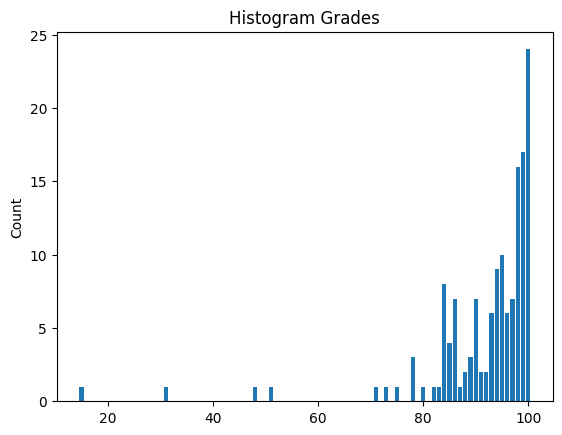

In [35]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [36]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#correct,#wrong,#previous,#confusion,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.205748,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,2.360919,27.688412
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,3.0,1.0,2.0,2.0,1.546771,0.178536


In [37]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#correct,#wrong,#previous,...,prompt_avg_chars,response_avg_chars,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,2.205748,212.206370,0.331379,0.399620,0.048617,0.440234,0.641061,0.000000,0.000000,0.054091
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.304163,113.633582,0.826481,0.242436,0.861056,0.561350,0.945530,0.734476,0.461421,0.131359
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,...,2.360919,27.688412,0.000000,0.029160,0.050492,0.601981,0.000000,0.042309,0.314819,0.000000
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.123346,107.092566,0.186717,0.108204,0.397893,0.116723,0.136957,0.044199,0.175412,0.402144
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,3.0,1.0,2.0,...,1.546771,0.178536,0.624653,0.117889,0.120113,0.113242,0.524058,0.081586,0.027432,0.330616


#### Merging scores with features

In [38]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#correct,#wrong,#previous,...,response_avg_chars,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,212.206370,0.331379,0.399620,0.048617,0.440234,0.641061,0.000000,0.000000,0.054091,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,113.633582,0.826481,0.242436,0.861056,0.561350,0.945530,0.734476,0.461421,0.131359,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,...,27.688412,0.000000,0.029160,0.050492,0.601981,0.000000,0.042309,0.314819,0.000000,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,...,107.092566,0.186717,0.108204,0.397893,0.116723,0.136957,0.044199,0.175412,0.402144,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,3.0,1.0,2.0,...,0.178536,0.624653,0.117889,0.120113,0.113242,0.524058,0.081586,0.027432,0.330616,100.0


In [46]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 20) (122,)


#### Train/Test split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
X_test

array([[-0.34303677, -0.58597744,  0.28969668,  1.35340737, -0.24678453,
        -0.19361565,  0.44924511, -0.37151881,  0.80125294, -0.18797098,
        -0.13007266, -0.04171577,  2.62563002, -0.25215112,  1.69167388,
        -0.77526793, -0.8581966 , -0.03849735,  0.53058457, -0.06477074],
       [-0.72440716, -0.03144269,  0.28969668, -0.28759907, -0.24678453,
        -0.68784507, -0.38876981, -0.37151881, -0.41314605, -0.94768701,
        -0.12859125,  0.23911869, -0.77315164,  1.02227647, -0.67397409,
        -1.07514227, -0.97086506, -0.94886774, -0.8363548 , -0.18630365],
       [ 0.8487457 ,  1.90942892,  0.28969668, -0.28759907, -0.24678453,
         3.10124716, -0.38876981, -0.37151881,  0.80125294,  0.57174505,
        -0.13369911, -0.27961772, -0.44610789, -0.55156718, -0.67145969,
        -0.49756253,  1.59800617,  1.73805759, -0.77771838, -1.13296881],
       [-0.20002287,  1.0776268 ,  0.28969668, -0.28759907, -0.24678453,
         0.46535691, -0.38876981, -0.37151881, -

#### Fitting a model

#### Predicting and Analyzing 

In [66]:
regressor = DecisionTreeRegressor(random_state=42,criterion='squared_error', max_depth=8, min_samples_split=3)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_split=3, random_state=42)

In [67]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 163.42034222552866
Node 1 has MSE 103.26909722222263
Node 2 has MSE 64.17839335179997
Node 3 has MSE 118.06243496358093
Node 4 has MSE 64.58710562414308
Node 5 has MSE 85.1388888888896
Node 6 has MSE 38.88888888888687
Node 7 has MSE 6.25
Node 8 has MSE 0.0
Node 9 has MSE 8.66666666666697
Node 10 has MSE 1.0
Node 11 has MSE 0.0
Node 12 has MSE 39.455782312925294
Node 13 has MSE 39.58222222222139
Node 14 has MSE 33.25
Node 15 has MSE 4.0
Node 16 has MSE 17.984375
Node 17 has MSE 10.639999999999418
Node 18 has MSE 0.5
Node 19 has MSE 0.0
Node 20 has MSE 3.805555555554747
Node 21 has MSE 0.25
Node 22 has MSE 0.0
Node 23 has MSE 0.0
Node 24 has MSE 0.25
Node 25 has MSE 194.5
Node 26 has MSE 44.222222222223536
Node 27 has MSE 0.0
Node 28 has MSE 1.0
Node 29 has MSE 0.0
Node 30 has MSE 24.3896484375
Node 31 has MSE 20.985431841831087
Node 32 has MSE 37.80555555555566
Node 33 has MSE 4.0
Node 34 has MSE 4.6875
Node 35 has MSE 1.5555555555547471
Node 36 has MSE 0.0
Node 37 has MS

In [68]:
# Plotting the Tree 
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [69]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 5.937605435801311
MSE TEST: 144.26678719008268
R2 Train: 0.9636666686965623
R2 TEST: -0.28504891249040387


In [70]:
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

In [71]:
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)


In [72]:
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))

MSE Train: 83.58953235302633
MSE TEST: 106.35976277272952
R2 Train: 0.48849983291756705
R2 TEST: 0.05260593830407956


In [73]:
from sklearn.model_selection import GridSearchCV

params = { 'eps': [0.001,0.002,0.003], 'selection' : ['cyclic', 'random']}
grid_search = GridSearchCV(estimator=reg, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LassoCV(cv=5, random_state=42),
             param_grid={'eps': [0.001, 0.002, 0.003],
                         'selection': ['cyclic', 'random']})

In [ ]:
import pandas as pd
pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')